In [2]:
from project_helper import TweetData, IntradayData, FuturesCloseData
import pandas as pd
import numpy as np
from pytz import timezone
import datetime
from datetime import timedelta  
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
instrument_list = ['ES', 'NQ', 'CD', 'EC', 'JY', 'MP', 'TY', 'US', 'C', 'S', 'W', 'CL', 'GC']
tweet_data = TweetData()
fc = FuturesCloseData()
fc.returns('ES',0,1).loc[pd.to_datetime('2016-10-03')]

-0.003912543153049482

Creating a pandas dataframe with daily log returns for all assets, and a text column which contains all tweets in that day (market close to market close)

In [4]:
daily_df = pd.read_csv('combined_daily_tweets.csv', header=None)
daily_df.columns =['date','text']
daily_df.date = pd.to_datetime(daily_df.date)
daily_df = daily_df.set_index('date')
# Start of training period
daily_df = daily_df[daily_df.index >= pd.to_datetime('2016-10-03')]
# Dropping NAs, ie days with no returns, like weekends and holidays
daily_df = daily_df.join(fc.log_returns()).dropna()

In [5]:
daily_df.head(3)

,text,ES,NQ,CD,EC,JY,MP,TY,US,C,S,W,CL,GC
date,,,,,,,,,,,,,,
2016-10-03,join me in henderson nevada on wednesday at am...,-0.003920,-0.001624,-0.006520,-0.001899,-0.011445,0.000233,-0.003515,-0.010427,0.005206,-0.007537,-0.000405,-0.002218,-0.031237
2016-10-04,join me in reno nevada on wednesday at pm at t...,0.003920,0.003147,0.002264,0.001239,-0.007687,0.005585,-0.002188,-0.004647,-0.001559,-0.004984,0.014093,0.020876,-0.000812
2016-10-05,the constant interruptions last night by tim k...,0.001495,-0.000295,-0.004598,-0.006168,-0.004767,-0.001626,-0.002071,-0.004262,-0.015195,0.001086,-0.014093,0.010994,-0.011587


- Creating dataframe with indices all the words in Trump's vocabulary, and rows the 1 day returns for each word for each day
- I clipped the return at 0.5% to avoid days with very large returns dominating the singal

In [6]:
word_ret_dict = {}
for inst in instrument_list:

    word_ret_df = pd.DataFrame(index = list(set(tweet_data.clean_tweets.tweets.str.cat(sep=' ').split())), 
                               columns = range(len(daily_df.index)))
    word_ret_df = word_ret_df.fillna(0)
    for i in tqdm(range(word_ret_df.shape[1])):
        num = daily_df[inst][i].clip(-0.05,0.05)
        word_ret_df[i].loc[daily_df.text[i].split()] = num
    word_ret_dict[inst] = word_ret_df

  0%|                                                  | 0/770 [00:00<?, ?it/s]C:\Users\PC\Anaconda3\envs\cs109a\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
100%|████████████████████████████████████████| 770/770 [01:48<00:00,  6.19it/s]


Creating a dataframe with mean cumulative returns from the dataframes created above. 

In [9]:
word_ret_cum_mean_dict = {}
for inst in tqdm(instrument_list):
    word_ret_cum_mean_dict[inst] = word_ret_dict[inst].cumsum(axis=1)/np.arange(1,word_ret_dict[inst].shape[1]+1)

Mean cumulative returns for daily tweets in the last day of the dataset, for S&P500 futures, sorted

In [14]:
word_ret_cum_mean_dict['ES'][769].sort_values().head(10)

getting    -0.000252
happy      -0.000238
paying     -0.000202
against    -0.000177
support    -0.000175
farmers    -0.000172
pelosi     -0.000172
spending   -0.000166
just       -0.000165
billion    -0.000163
Name: 769, dtype: float64

- Creating feature: Average cumulative word returns as of yesterday, for every word in the daily tweets. This is a return for all the words Trump tweeted in a day. 
- Considering only days where he tweeted more than 10 words to avoid noise of single word returns.

In [17]:
for inst in tqdm(instrument_list):
    vc = np.zeros(daily_df.shape[0])
    for i in range(1, daily_df.shape[0]):
        sp = daily_df.text[i].split()
        if len(sp) <=10:
            vc[i] = 0
        else:
            vc[i]= sum(word_ret_cum_mean_dict[inst][i-1].loc[sp]/len(sp))
    daily_df['{}_trump_ret_d'.format(inst)] = vc

100%|██████████████████████████████████████████| 13/13 [00:12<00:00,  1.00s/it]


In [19]:
daily_df.columns

Index(['text', 'ES', 'NQ', 'CD', 'EC', 'JY', 'MP', 'TY', 'US', 'C', 'S', 'W',
       'CL', 'GC', 'ES_trump_ret_d', 'NQ_trump_ret_d', 'CD_trump_ret_d',
       'EC_trump_ret_d', 'JY_trump_ret_d', 'MP_trump_ret_d', 'TY_trump_ret_d',
       'US_trump_ret_d', 'C_trump_ret_d', 'S_trump_ret_d', 'W_trump_ret_d',
       'CL_trump_ret_d', 'GC_trump_ret_d'],
      dtype='object')

Now, we are going to get word returns for every tweet.

Getting single tweet data, with timestamp.

In [20]:
daily_tweets = tweet_data.clean_tweets[pd.to_datetime(tweet_data.clean_tweets.after4_date)
                                       <= pd.to_datetime(daily_df.index[-1])]
daily_tweets.after4_date = pd.to_datetime(daily_tweets.after4_date)

C:\Users\PC\Anaconda3\envs\cs109a\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [21]:
daily_tweets.head()

,tweets,timestamp,after4_date
timestamp,,,
2019-11-07 14:51:38-06:00,what did hunter biden do for the money a very ...,2019-11-07 14:51:38-06:00,2019-11-07
2019-11-07 14:00:34-06:00,based on the information released last night a...,2019-11-07 14:00:34-06:00,2019-11-07
2019-11-07 13:47:57-06:00,read the transcript,2019-11-07 13:47:57-06:00,2019-11-07
2019-11-07 13:46:30-06:00,the degenerate washington post made up the sto...,2019-11-07 13:46:30-06:00,2019-11-07
2019-11-07 12:28:41-06:00,bill barr did not decline my request to talk a...,2019-11-07 12:28:41-06:00,2019-11-07


Creating a dictionary of dates as keys and indices as values, to match the format of the return matrices above. Adding an indicator row to daily_tweets dataframe with the day, and then removing all days with no returns (like on weekends and holidays)

In [22]:
date_dict = {date : i for i,date in enumerate(daily_df.index)}
daily_tweets['ind']=[date_dict[date] if date in date_dict.keys() else 0 for date in daily_tweets.after4_date]
daily_tweets = daily_tweets[daily_tweets.ind!=0]

C:\Users\PC\Anaconda3\envs\cs109a\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Calculating returns for every tweet

In [23]:
for inst in tqdm(instrument_list):
    tc = np.zeros(daily_tweets.shape[0])
    i = 0
    for tweet, ind  in zip(daily_tweets.tweets,daily_tweets.ind):
        tw = tweet.split()
        if ind > 0:
            if len(tw) <=10:
                tc[i] = 0
            else:
                tc[i]= sum(word_ret_cum_mean_dict[inst][ind-1].loc[tw])
        i = i+1
    daily_tweets['{}_single_ret'.format(inst)] = tc
    

100%|██████████████████████████████████████████| 13/13 [00:59<00:00,  4.61s/it]


In [24]:
daily_tweets.columns

Index(['tweets', 'timestamp', 'after4_date', 'ind', 'ES_single_ret',
       'NQ_single_ret', 'CD_single_ret', 'EC_single_ret', 'JY_single_ret',
       'MP_single_ret', 'TY_single_ret', 'US_single_ret', 'C_single_ret',
       'S_single_ret', 'W_single_ret', 'CL_single_ret', 'GC_single_ret'],
      dtype='object')

Removing tweets with exactly zero return, which are most likely tweets with less than 10 words.

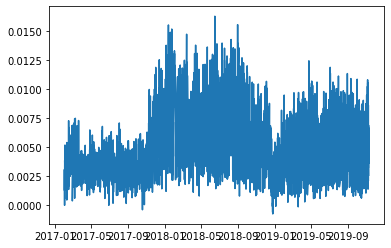

In [26]:
daily_tweets = daily_tweets[daily_tweets.ES_single_ret!=0]
plt.plot(daily_tweets[daily_tweets.after4_date >= pd.to_datetime('2017-02-01')].ES_single_ret)
final_daily_tweets = daily_tweets[daily_tweets.after4_date >= pd.to_datetime('2017-02-01')]

The features: Return of the single tweet with the highest return yesterday and lowest return yesterday

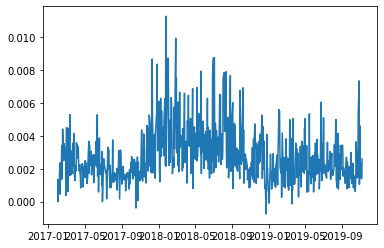

In [27]:
plt.plot(final_daily_tweets.groupby('after4_date').min().ES_single_ret)

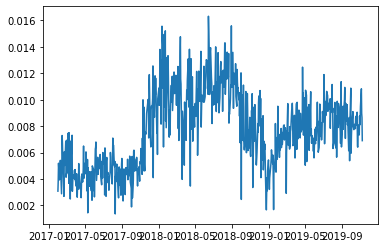

In [28]:
plt.plot(final_daily_tweets.groupby('after4_date').max().ES_single_ret)